In [13]:
import sys
import numpy as np
from pympler import asizeof

import numpy as np
import sys
from pympler import asizeof

class NumpyBitpackedDict:
    def __init__(self, initial_size=1024, load_factor=0.7):
        self.size = initial_size
        self.used = 0
        self.keys = np.zeros(self.size, dtype=np.uint32)
        self.values = np.array([None] * self.size, dtype=object)
        self.PRIME1 = self._largest_prime_up_to(self.size)
        self.load_factor = load_factor

    def _next_prime(self, n):
        def is_prime(k):
            if k < 2: return False
            for i in range(2, int(k**0.5) + 1):
                if k % i == 0: return False
            return True
        while not is_prime(n):
            n += 1
        return n
    
    def _largest_prime_up_to(self, n):
        if n < 2:
            return None
        
        # Optimize by only considering odd numbers (except 2)
        is_prime = [True] * ((n // 2) + 1)
        is_prime[0] = False  # 1 is not prime

        for i in range(3, int(n**0.5) + 1, 2):
            if is_prime[i // 2]:
                # Mark odd multiples of i as not prime
                start = (i * i) // 2
                end = (n // 2) + 1
                step = i
                is_prime[start:end:step] = [False] * len(range(start, end, step))

        # Check if the largest number is prime
        if n % 2 == 1 and is_prime[n // 2]:
            return n

        # Find the largest odd number which is still marked as prime
        for i in range((n-1) | 1, 1, -2):  # Start from largest odd number not exceeding n
            if is_prime[i // 2]:
                return i

        return 2  # If no odd prime found, return 2

    def __contains__(self, key):
        packed_key = self._pack_key(*key)
        index = self._find_slot(packed_key)
        return self.values[index] is not None

    def __setitem__(self, key, value):
        packed_key = self._pack_key(*key)
        index = self._find_slot(packed_key)
        
        if self.values[index] is None:
            self.used += 1
            
        self.keys[index] = packed_key
        self.values[index] = value
        
        if self.used > self.load_factor * self.size:
            self._resize()

    def __getitem__(self, key):
        packed_key = self._pack_key(*key)
        index = self._find_slot(packed_key)
        
        if self.values[index] is None:
            raise KeyError(key)
        
        return self.values[index]

    # TODO: Let bitsplit of img_id and concept_id be configurable
    def _pack_key(self, img_id, concept_id):
        if img_id < 0 or img_id >= (1 << 22):
            raise ValueError("img_id must be between 0 and 2^22 - 1")
        if concept_id < 0 or concept_id >= (1 << 10):
            import math
            print(math.log2(concept_id), 'this is concept id', concept_id)
            raise ValueError("concept_id must be between 0 and 2^10 - 1")
        return np.uint32((img_id << 10) | concept_id)
    
    def _hash1(self, key):
        return key % self.size

    def _hash2(self, key):
        return self.PRIME1 - (key % self.PRIME1)

    def _find_slot(self, packed_key):
        index = self._hash1(packed_key)
        # step = 2*self._hash2(packed_key)+1 # Always odd (coprime to size which is always power of 2)
        step = self._hash2(packed_key)

        # print(f"Finding slot for {packed_key} with index {index} and step {step}")
        
        while self.values[index] is not None and self.keys[index] != packed_key:
            index = (index + step) % self.size
        return index
        
    def _resize(self):
        old_keys, old_values = self.keys, self.values
        self.size = self.size * 2
        self.used = 0
        self.keys = np.zeros(self.size, dtype=np.uint32)
        self.values = np.array([None] * self.size, dtype=object)

        # self.PRIME1 = self.__get_largest_prime(self.size - 1)
        # self.PRIME1 = self._next_prime(self.size // 2 - 1)
        self.PRIME1 = self._largest_prime_up_to(self.size)
        
        for key, value in zip(old_keys, old_values):
            if value is not None:
                index = self._find_slot(key)
                self.keys[index] = key
                self.values[index] = value
                self.used += 1

    def memory_usage(self):
        expected_size = (
            self.size * (
                np.dtype(np.uint32).itemsize +  # keys
                np.dtype(object).itemsize       # values
            )
        )
        return {
            'shallow': sum(sys.getsizeof(arr) for arr in [self.keys, self.values]),
            'deep': asizeof.asizeof(self.keys) + asizeof.asizeof(self.values),
            'expected': expected_size
        }


In [48]:
import random 
from tqdm import tqdm
from time import time
inserted_values = []
times = []

def split_32bit_number(number):
    # Ensure the number is 32 bits
    number = number & 0xFFFFFFFF
    
    # Extract the first 22 bits
    first_22_bits = (number >> 10) & 0x3FFFFF
    
    # Extract the last 10 bits
    last_10_bits = number & 0x3FF
    
    return first_22_bits, last_10_bits


d = NumpyBitpackedDict()
for i in tqdm(range(9_500_000)):
    # img_id = random.randint(0, 2**22 - 2)
    # concept_id = random.randint(0, 2**10 - 2)
    img_id, concept_id = split_32bit_number(i)
    # print(concept_id, 'is concept id')
    value = random.randint(0, 2**25)
    if (img_id, concept_id) in d:
        print('huh')
        continue

    t1 = time()
    d[img_id, concept_id] = value
    # if i% 25_000 == 0:
    times.append(time() - t1)

    inserted_values.append((concept_id, img_id, value))




1021 1024


100%|██████████| 9500000/9500000 [01:37<00:00, 97059.38it/s] 


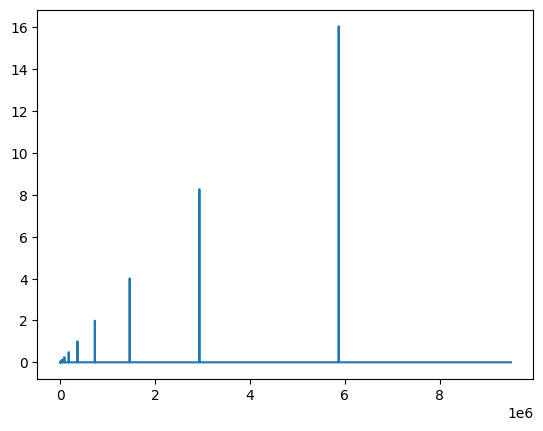

In [49]:
import matplotlib.pyplot as plt

plt.plot(times)

In [50]:
wrong = 0
for idx, (concept_id, img_id, value) in enumerate(inserted_values):
    if d[img_id, concept_id] != value:
        wrong += 1

print(wrong / len(inserted_values))
print(wrong)


0.0
0


In [5]:
def largest_prime_up_to(n):
    if n < 2:
        return None
    
    # Optimize by only considering odd numbers (except 2)
    is_prime = [True] * ((n // 2) + 1)
    is_prime[0] = False  # 1 is not prime

    for i in range(3, int(n**0.5) + 1, 2):
        if is_prime[i // 2]:
            # Mark odd multiples of i as not prime
            start = (i * i) // 2
            end = (n // 2) + 1
            step = i
            is_prime[start:end:step] = [False] * len(range(start, end, step))

    # Check if the largest number is prime
    if n % 2 == 1 and is_prime[n // 2]:
        return n

    # Find the largest odd number which is still marked as prime
    for i in range((n-1) | 1, 1, -2):  # Start from largest odd number not exceeding n
        if is_prime[i // 2]:
            return i

    return 2  # If no odd prime found, return 2

# Test the function
print(largest_prime_up_to(5_000_000))

4999999
